# Imports

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


# Preparing data

In [28]:
train_path = './myArchive/train'
test_path = './AI'
valid_path = './myArchive/valid'

img_size = 256
batch_size = 16

# Define ImageDataGenerators for loading and augmenting the data
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' )
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for each set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

class_names = list(train_generator.class_indices.keys())
class_names_len = len(class_names)

class Metrics(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(Metrics, self).__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.train_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        val_data = self.validation_data
        train_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        train_targ = np.argmax(self.validation_data[1], axis=1)
        train_f1 = f1_score(train_targ, train_predict, average='macro')
        self.train_f1s.append(train_f1)

        val_predict = np.argmax(self.model.predict(val_data[0]), axis=1)
        val_targ = np.argmax(val_data[1], axis=1)
        val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(val_f1)

        print(f'Epoch {epoch+1} — Train F1: {train_f1:.4f} — Val F1: {val_f1:.4f}')
        return

validation_data = (valid_generator[0][0], valid_generator[0][1])

# Display class names
print("Class names:", class_names)

Found 1946 images belonging to 10 classes.
Found 493 images belonging to 10 classes.
Found 400 images belonging to 10 classes.
Class names: ['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']


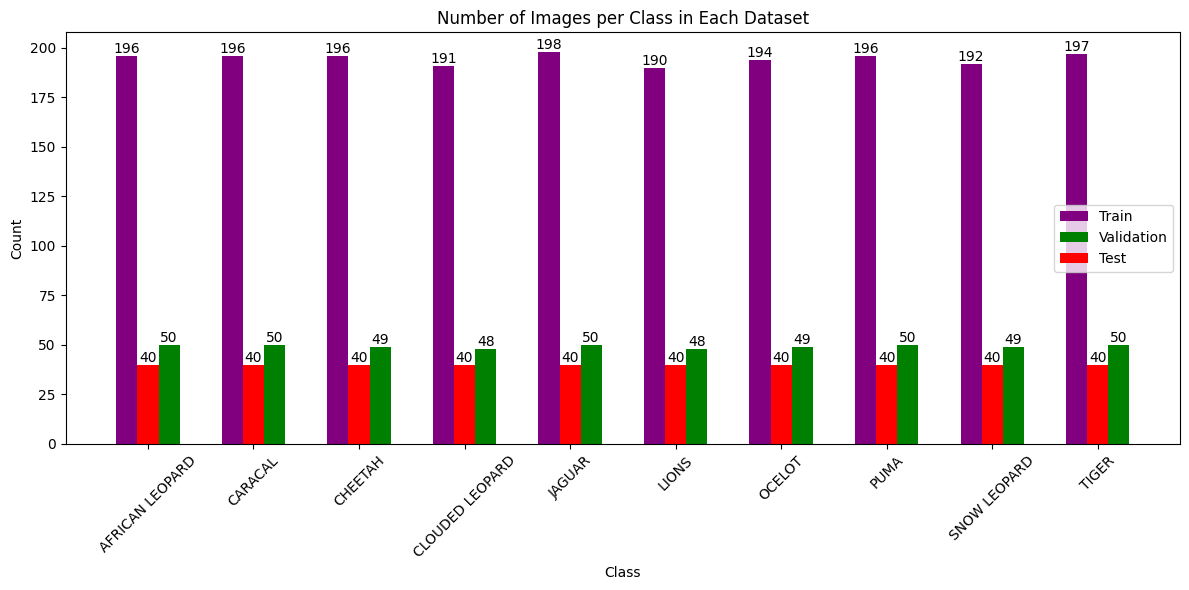

In [51]:
class_labels = list(train_generator.class_indices.keys())

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                '%d' % int(height), ha='center', va='bottom')

def fill_class_count(generator):
    class_count = {label: 0 for label in class_labels}
    for i in range(len(generator)):
        batch_data, batch_labels = generator[i]
        for j in range(len(batch_data)):
            class_idx = int(batch_labels[j].argmax())
            class_label = class_labels[class_idx]
            class_count[class_label] += 1
    return class_count

counts_train = list(fill_class_count(train_generator).values())
counts_valid = list(fill_class_count(valid_generator).values())
counts_test = list(fill_class_count(test_generator).values())

x = np.arange(len(class_labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

add_labels(ax.bar(x - width, counts_train, width, label='Train', color='purple'))
add_labels(ax.bar(x + width, counts_valid, width, label='Validation', color='green'))
add_labels(ax.bar(x, counts_test, width, label='Test', color='red'))

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Number of Images per Class in Each Dataset')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()

fig.tight_layout()
fig.savefig(f"./results/imagesSpread.png")
plt.show()

# Training

### Custom model

In [29]:
# Build the model
model_custom = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_names_len, activation='softmax'),
])

# Compile the model
model_custom.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
metrics_custom = Metrics(validation_data)

c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### EfficientNetB0

In [30]:
# Load EfficientNetB0 model with pre-trained weights
base_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
base_effnet.trainable = True

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_effnet.output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_effnet = Dense(class_names_len, activation='softmax')(x)

model_effnet = Model(inputs=base_effnet.input, outputs=output_effnet)

# Compile the model
model_effnet.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
metrics_effnet = Metrics(validation_data)

### ResNet50

In [31]:
# Load the pre-trained ResNet50 model without the top classification layer
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

base_resnet.trainable = True

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_resnet.output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_resnet = Dense(class_names_len, activation='softmax')(x)

# Create the final model
model_resnet = Model(inputs=base_resnet.input, outputs=output_resnet)

# Compile the model
model_resnet.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
metrics_resnet = Metrics(validation_data)

# MobNet

In [32]:
# Load the pre-trained ResNet50 model without the top classification layer
base_mobnet = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

base_mobnet.trainable = True

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_mobnet.output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_mobnet = Dense(class_names_len, activation='softmax')(x)

# Create the final model
model_mobnet = Model(inputs=base_mobnet.input, outputs=output_mobnet)

# Compile the model
model_mobnet.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
metrics_mobnet = Metrics(validation_data)

C:\Users\Poka\AppData\Local\Temp\ipykernel_5668\2842606159.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobnet = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


## Train models

In [33]:
epohs = 40

history_custom = model_custom.fit(
    train_generator,
    epochs=epohs,
    validation_data=valid_generator,
    callbacks=[cp_callback, metrics_custom])

history_resnet = model_resnet.fit(
    train_generator,
    epochs=epohs,
    validation_data=valid_generator,
    callbacks=[metrics_resnet])

history_mobnet = model_mobnet.fit(
    train_generator,
    epochs=epohs,
    validation_data=valid_generator,
    callbacks=[metrics_mobnet])

history_effnet = model_effnet.fit(
    train_generator,
    epochs=epohs,
    validation_data=valid_generator,
    callbacks=[metrics_effnet])

histories = [
    ('Custom', history_custom, metrics_custom.train_f1s, metrics_custom.val_f1s),
    ('Resnet', history_resnet, metrics_resnet.train_f1s, metrics_resnet.val_f1s),
    ('Mobnet', history_mobnet, metrics_mobnet.train_f1s, metrics_mobnet.val_f1s),
    ('Effnet', history_effnet, metrics_effnet.train_f1s, metrics_effnet.val_f1s)
]

Epoch 1/40


c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.1101 - loss: 2.6388
Epoch 1: saving model to training_1/cp.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1 — Train F1: 0.0556 — Val F1: 0.0556
122/122 ━━━━━━━━━━━━━━━━━━━━ 35s 273ms/step - accuracy: 0.1103 - loss: 2.6364 - val_accuracy: 0.1663 - val_loss: 2.2488
Epoch 2/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1820 - loss: 2.1572
Epoch 2: saving model to training_1/cp.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 2 — Train F1: 0.2857 — Val F1: 0.2857
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 264ms/step - accuracy: 0.1821 - loss: 2.1570 - val_accuracy: 0.2231 - val_loss: 2.0554
Epoch 3/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.2400 - loss: 2.0372
Epoch 3: saving model to training_1/cp.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 3 — Train F1: 0.2857 — Val F1: 0.28

# Testing the model

In [34]:
for idx, (label, history, train_f1s, val_f1s) in enumerate(histories):
    directory = f'./{label}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(f'./{label}/training_history.json', 'w') as f:
        json.dump(history.history, f)
    with open(f'./{label}/training_f1_train.json', 'w') as f:
        json.dump(train_f1s, f)
    with open(f'./{label}/training_f1_val.json', 'w') as f:
        json.dump(val_f1s, f)

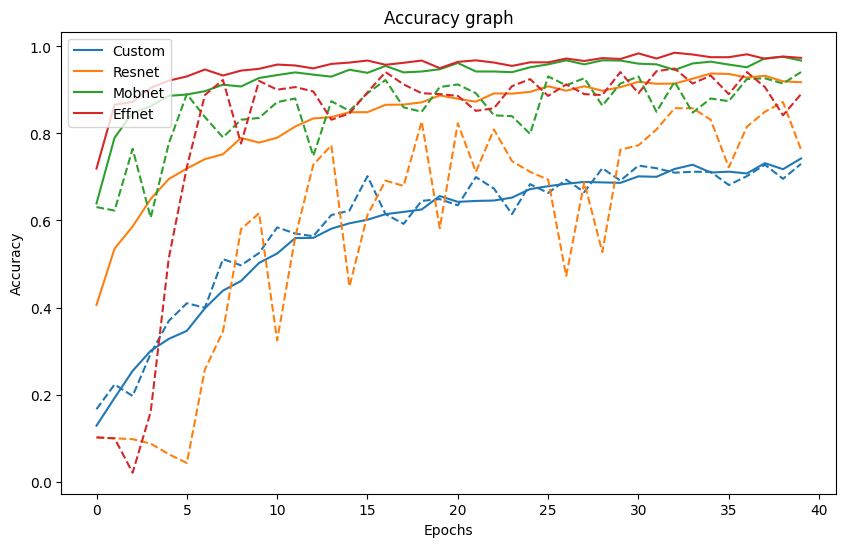

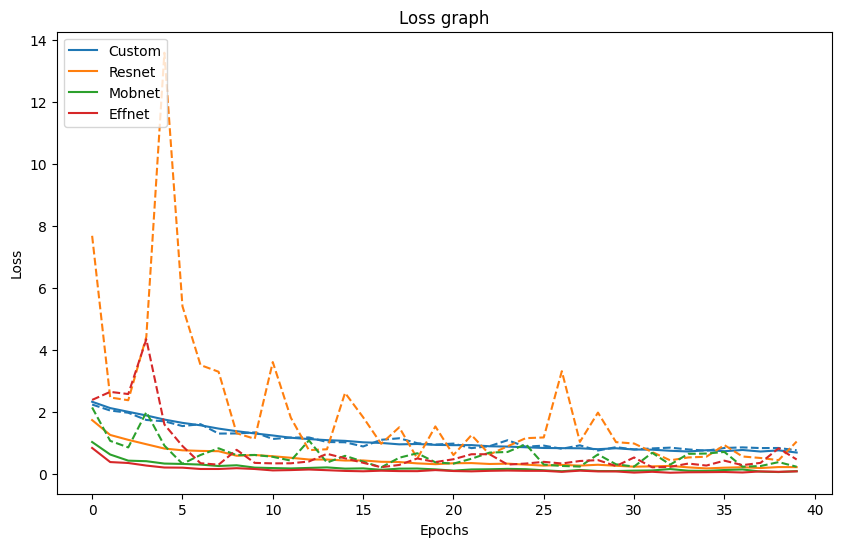

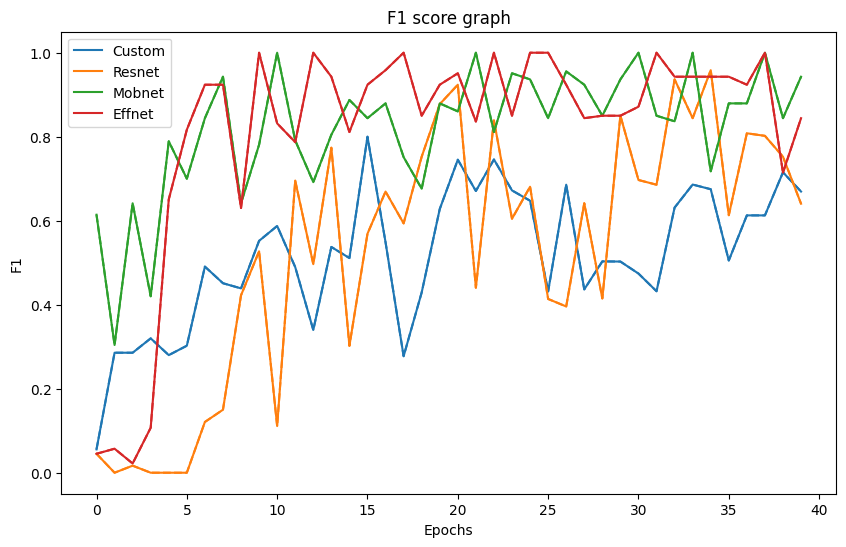

In [35]:
def create_plot(title, axName, data):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    for idx, (label, test, val) in enumerate(data):
        color = colors[idx]
        ax1.plot(test, label=f'{label}', color=color)
        ax1.plot(val, color=color, linestyle='dashed')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(axName)
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    plt.title(title)
    plt.show()

    fig.savefig(f"./results/{title}.png")
    plt.close()



accuracies = [
    ('Custom', history_custom.history['accuracy'], history_custom.history['val_accuracy']),
    ('Resnet', history_resnet.history['accuracy'], history_resnet.history['val_accuracy']),
    ('Mobnet', history_mobnet.history['accuracy'], history_mobnet.history['val_accuracy']),
    ('Effnet', history_effnet.history['accuracy'], history_effnet.history['val_accuracy']),
]

loss = [
    ('Custom', history_custom.history['loss'], history_custom.history['val_loss']),
    ('Resnet', history_resnet.history['loss'], history_resnet.history['val_loss']),
    ('Mobnet', history_mobnet.history['loss'], history_mobnet.history['val_loss']),
    ('Effnet', history_effnet.history['loss'], history_effnet.history['val_loss']),
]


f1 = [
    ('Custom', metrics_custom.train_f1s, metrics_custom.val_f1s),
    ('Resnet', metrics_resnet.train_f1s, metrics_resnet.val_f1s),
    ('Mobnet', metrics_mobnet.train_f1s, metrics_mobnet.val_f1s),
    ('Effnet', metrics_effnet.train_f1s, metrics_effnet.val_f1s),
]

create_plot('Accuracy graph', 'Accuracy', accuracies)
create_plot('Loss graph', 'Loss', loss)
create_plot('F1 score graph', 'F1', f1)

In [36]:
# Gather true labels
true_labels = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))
true_labels = np.array(true_labels)

def save_classification_report(label, classification_report):
    report_data = []
    lines = classification_report.split('\n')
    for line in lines[2:-3]:  # skip header, skip last 3 lines (micro/macro avg and support)
        row = {}
        row_data = line.strip().split()
        if len(row_data) == 5:  # Assuming format is [class, precision, recall, f1-score, support]
            row['class'] = row_data[0]
            row['precision'] = float(row_data[1])
            row['recall'] = float(row_data[2])
            row['f1-score'] = float(row_data[3])
            row['support'] = int(row_data[4])
        elif len(row_data) > 5:  # If class name has spaces and is split into multiple parts
            row['class'] = ' '.join(row_data[:-4])
            row['precision'] = float(row_data[-4])
            row['recall'] = float(row_data[-3])
            row['f1-score'] = float(row_data[-2])
            row['support'] = int(row_data[-1])
        else:
            continue  # Skip unexpected lines
        report_data.append(row)


    df = pd.DataFrame(report_data)

    # Plotting the DataFrame as a table
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    plt.title(label)

    # Save the plot as a PNG file
    plt.savefig(f'./results/{label}classification_report.png')
    plt.show()
    plt.close()

c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step
Custom Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.82      0.35      0.49        40
        CARACAL       1.00      0.05      0.10        40
        CHEETAH       0.48      0.33      0.39        40
CLOUDED LEOPARD       0.22      0.23      0.22        40
         JAGUAR       0.11      0.03      0.04        40
          LIONS       0.25      0.05      0.08        40
         OCELOT       0.22      0.45      0.29        40
           PUMA       0.21      0.78      0.34        40
   SNOW LEOPARD       0.38      0.33      0.35        40
          TIGER       0.35      0.30      0.32        40

       accuracy                           0.29       400
      macro avg       0.41      0.29      0.26       400
   weighted avg       0.41      0.29      0.26       400



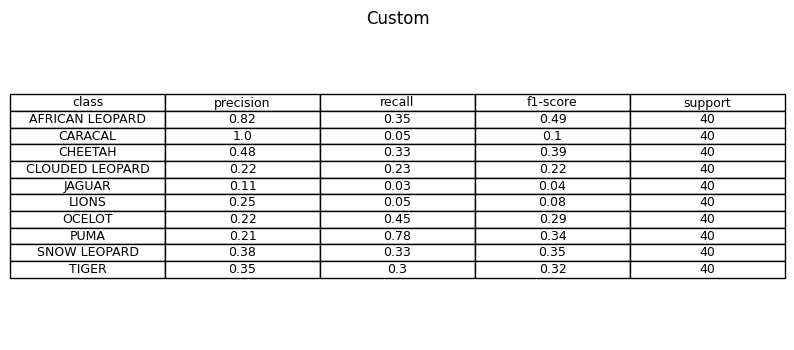

In [37]:
predicted_labels_custom = np.argmax(model_custom.predict(test_generator), axis=1)
f1_score_custom = f1_score(true_labels, predicted_labels_custom, average='weighted')

report_custom = classification_report(true_labels, predicted_labels_custom, target_names=class_names)
print('Custom Classification Report:\n',report_custom)
save_classification_report('Custom',report_custom)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 325ms/step
ResNet Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.10      0.17      0.13        40
        CARACAL       0.07      0.07      0.07        40
        CHEETAH       0.06      0.03      0.04        40
CLOUDED LEOPARD       0.08      0.03      0.04        40
         JAGUAR       0.08      0.15      0.11        40
          LIONS       0.00      0.00      0.00        40
         OCELOT       0.00      0.00      0.00        40
           PUMA       0.16      0.23      0.18        40
   SNOW LEOPARD       0.03      0.05      0.04        40
          TIGER       0.05      0.03      0.03        40

       accuracy                           0.07       400
      macro avg       0.06      0.08      0.06       400
   weighted avg       0.06      0.07      0.06       400



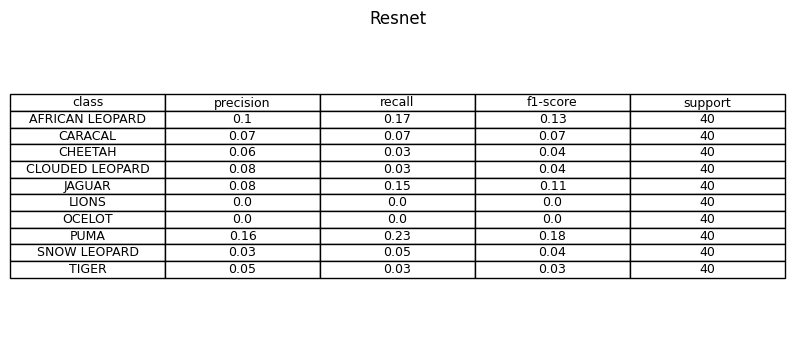

In [38]:
predicted_labels_resnet = np.argmax(model_resnet.predict(test_generator), axis=1)
f1_score_resnet = f1_score(true_labels, predicted_labels_resnet, average='weighted')

report_resnet = classification_report(true_labels, predicted_labels_resnet, target_names=class_names)
print('ResNet Classification Report:\n', report_resnet)
save_classification_report('Resnet',report_resnet)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step
Mobnet Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.05      0.03      0.03        40
        CARACAL       0.12      0.05      0.07        40
        CHEETAH       0.04      0.03      0.03        40
CLOUDED LEOPARD       0.12      0.05      0.07        40
         JAGUAR       0.09      0.07      0.08        40
          LIONS       0.14      0.07      0.10        40
         OCELOT       0.07      0.05      0.06        40
           PUMA       0.11      0.57      0.19        40
   SNOW LEOPARD       0.20      0.05      0.08        40
          TIGER       0.07      0.05      0.06        40

       accuracy                           0.10       400
      macro avg       0.10      0.10      0.08       400
   weighted avg       0.10      0.10      0.08       400



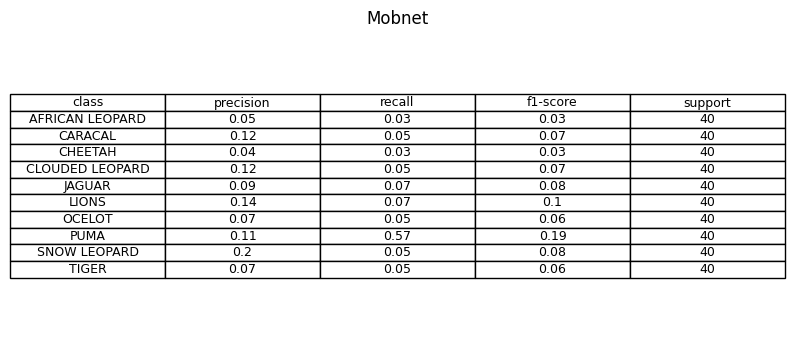

In [39]:
predicted_labels_mobnet = np.argmax(model_mobnet.predict(test_generator), axis=1)
f1_score_mobnet = f1_score(true_labels, predicted_labels_mobnet, average='weighted')

report_mobnet = classification_report(true_labels, predicted_labels_mobnet, target_names=class_names)
print('Mobnet Classification Report:\n', report_mobnet)
save_classification_report('Mobnet',report_mobnet)

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step
EffNet Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.13      0.28      0.18        40
        CARACAL       0.10      0.33      0.15        40
        CHEETAH       0.00      0.00      0.00        40
CLOUDED LEOPARD       0.07      0.10      0.08        40
         JAGUAR       0.12      0.07      0.09        40
          LIONS       0.11      0.15      0.12        40
         OCELOT       0.00      0.00      0.00        40
           PUMA       0.00      0.00      0.00        40
   SNOW LEOPARD       0.00      0.00      0.00        40
          TIGER       0.00      0.00      0.00        40

       accuracy                           0.09       400
      macro avg       0.05      0.09      0.06       400
   weighted avg       0.05      0.09      0.06       400



c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

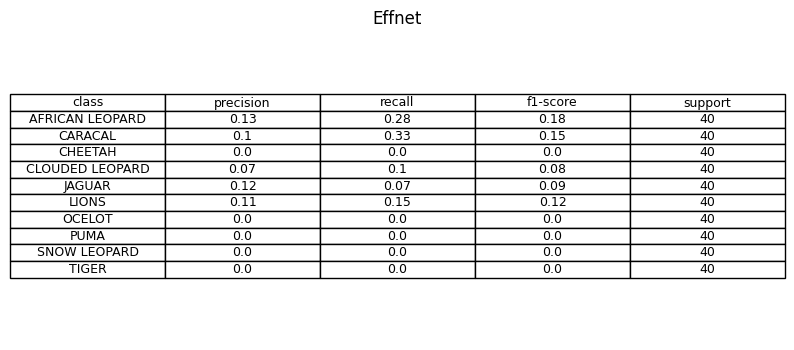

In [40]:
predicted_labels_effnet = np.argmax(model_effnet.predict(test_generator), axis=1)
f1_score_effnet = f1_score(true_labels, predicted_labels_effnet, average='weighted')

report_effnet = classification_report(true_labels, predicted_labels_effnet, target_names=class_names)
print('EffNet Classification Report:\n', report_effnet)
save_classification_report('Effnet',report_effnet)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.2483 - loss: 3.3905
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.3980 - loss: 2.2877
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.2895 - loss: 2.3798
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.2884 - loss: 3.7696


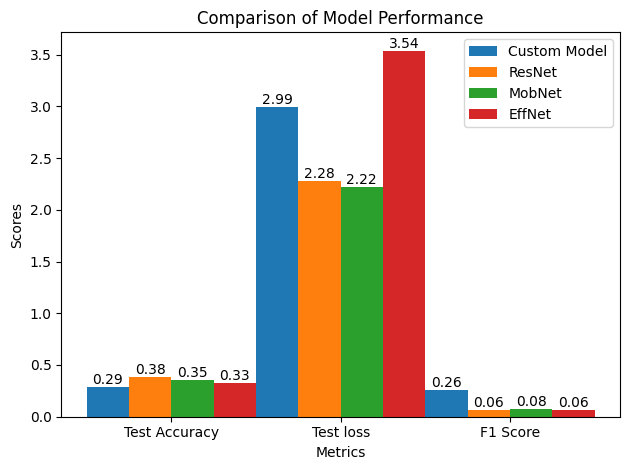

In [41]:
# Evaluate the model on the test dataset
test_loss_custom, test_acc_custom = model_custom.evaluate(test_generator)
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_generator)
test_loss_mobnet, test_acc_mobnet = model_mobnet.evaluate(test_generator)
test_loss_effnet, test_acc_effnet = model_effnet.evaluate(test_generator)

labels = ['Test Accuracy', 'Test loss', 'F1 Score']
custom_model_graph_data = [test_acc_custom, test_loss_custom, f1_score_custom]
resnet_model_graph_data = [test_acc_resnet, test_loss_resnet, f1_score_resnet]
mobnet_model_graph_data = [test_acc_mobnet, test_loss_mobnet, f1_score_mobnet]
effnet_model_graph_data = [test_acc_effnet, test_loss_effnet, f1_score_effnet]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5 * width, custom_model_graph_data, width, label='Custom Model')
rects2 = ax.bar(x - 0.5 * width, resnet_model_graph_data, width, label='ResNet')
rects3 = ax.bar(x + 0.5 * width, mobnet_model_graph_data, width, label='MobNet')
rects4 = ax.bar(x + 1.5 * width, effnet_model_graph_data, width, label='EffNet')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2., 
            height, 
            f'{height:.2f}', 
            ha='center', 
            va='bottom'
        )

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

fig.tight_layout()

plt.show()

fig.savefig("./results/resultsBarChart.png")
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


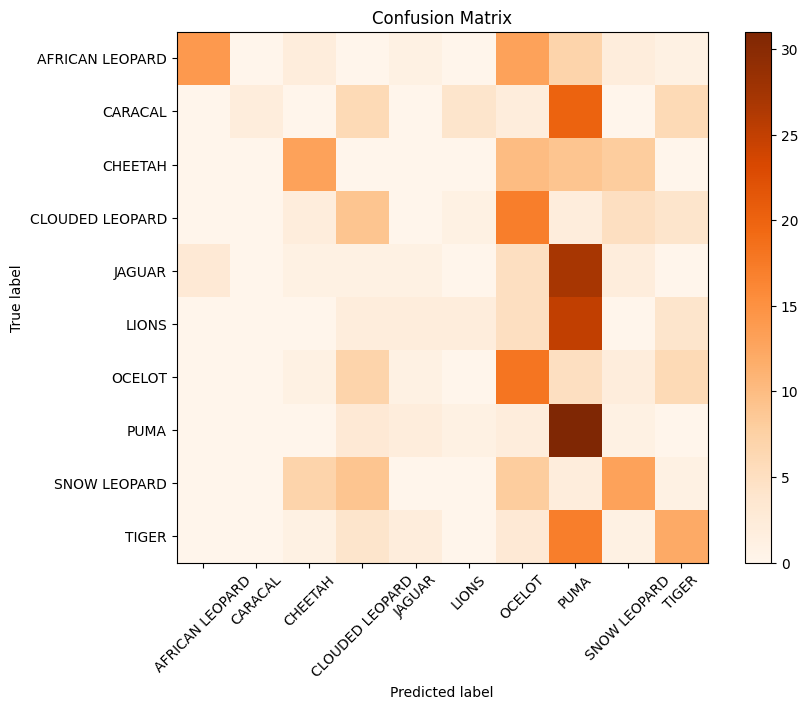

In [42]:
true_labels = []
predicted_labels = []

for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    predictions = model_custom.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

fig = plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(class_names_len)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

fig.savefig("./results/confusionMatrix.png")
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


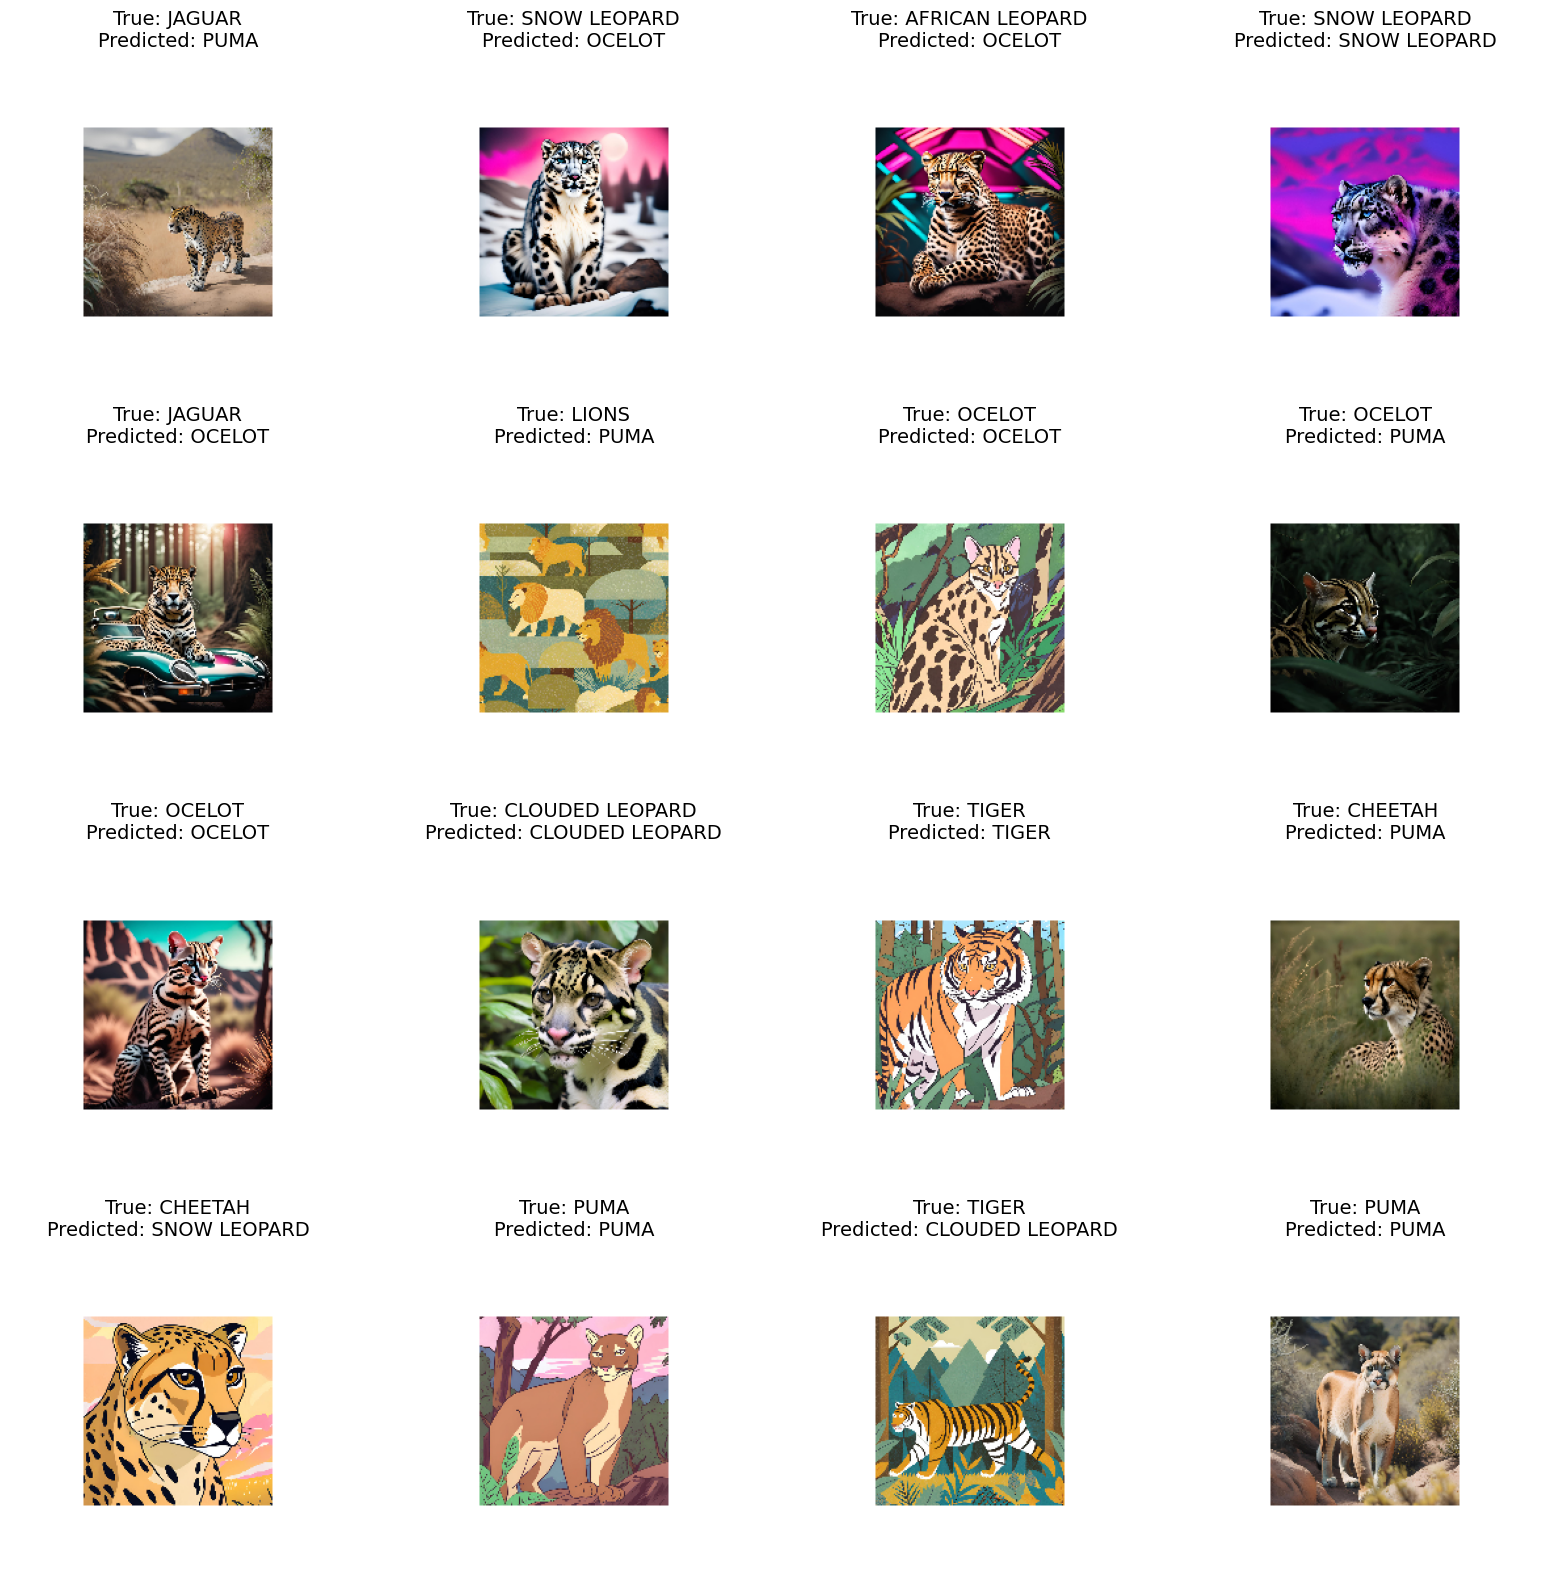

In [43]:
# Collect true labels and model predictions
x_batch, y_batch = test_generator[0]
predictions = model_custom.predict(x_batch)
true_labels = np.argmax(y_batch, axis=1)  # Convert one-hot encoded labels to class indices
predicted_labels = np.argmax(predictions, axis=1)

true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Plot true labels and predicted labels
fig = plt.figure(figsize=(16, 16))
for i in range(min(16, len(x_batch))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


fig.savefig("./results/dataDisplay.png")
plt.close()